In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.signal
import IPython.display as ipd

import sys
sys.path.append('../..')
from app.core.audio.AudioData import AudioData
from app.core.audio.AudioPlayer import AudioPlayer
from app.algorithms.pitch.Yin import Yin
from app.algorithms.pitch.PYin2 import PYin
from app.algorithms.pitch.Filter import Filter
from app.algorithms.pitch.Pitch import Pitch, PitchConfig, PitchConversion

# PYIN algorithm

## Preprocessing: High-pass IIR filter

Based on the filter implemented in *McLeod 2008*, we preprocess the audio signal with a 2nd order **IIR (infinite impulse response) filter** to lower the intensity of low frequency noise. We only lower the intensity, not remove completely, to retain harmonic information / contours which may be contained within the lower registers. We do this to improve the accuracy of pitch detection for musical signals, in a way which mimics how humans actually perceive lower frequencies at lower intensities.


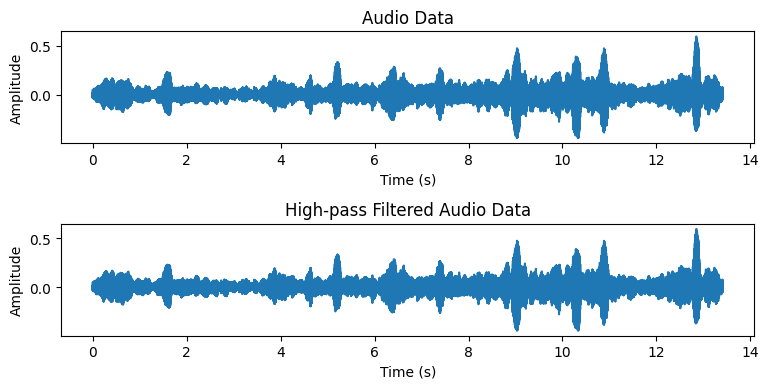

In [3]:
import matplotlib.pyplot as plt
import numpy as np

AUDIO_FILEPATH = '../data/audio_files/user_fugue2.mp3'
audio_data = AudioData(audio_filepath=AUDIO_FILEPATH)

# Create a figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 4))

SAMPLE_RATE = 44100
iir_audio = Filter.high_pass_iir_filter(audio_data.data, SAMPLE_RATE)

# plot: original audio
times = np.arange(len(audio_data.data)) / SAMPLE_RATE # show time (sec) on x-axis

axs[0].plot(times, audio_data.data)
axs[0].set_title('Audio Data')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

# plot: high pass IIR filtered audio
axs[1].plot(times, iir_audio)
axs[1].set_title('High-pass Filtered Audio Data')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')

fig.tight_layout()
plt.show()

### Playback both filtered and non-filtered audio
There is a very slight difference, IRR filtered is a little more pointed in sound, with less resonance effects.

In [4]:
# Playback both types of audio

AUDIO_FILEPATH = '../data/audio_files/user_fugue2.mp3'
SAMPLE_RATE = 44100

# load in the audio and run this cell
audio_data = AudioData(audio_filepath=AUDIO_FILEPATH)
iir_audio = Filter.high_pass_iir_filter(audio_data.data, SAMPLE_RATE)

iir_audio_data = AudioData()
iir_audio_data.write_data(iir_audio)

audio_player = AudioPlayer() # create audio player

# load + play original audio
# audio_player.load_audio_data(audio_data)
# audio_player.play()

# load + play IIR filtered audio
# audio_player.load_audio_data(iir_audio_data)
# audio_player.play()

## Phase 1: YIN CMNDF
Basic idea: Find fundamental frequency for a given frame of audio data by comparing how different the original signal is to a signal shifted over by some lag. The amount of lag it shifts over which minimizes this difference is the fundamental period.

### Steps
1. Fast computation of autocorrelation with FFT (wiener khinchin theorem)
    - also returns a power spectrum - mean squared amplitude at each frequency line, no phase information

2. Use the autocorrelation $r_t$ to compute a difference function $d_t$ using the following equality
$$d_t(\tau)=r_t(0)+r_{t+\tau}(0)-2r_t(\tau)$$

3. and normalize each $d_t(\tau)$ value for all lags
based on the cumulative mean of all differences leading up to that point
    - since first lag $d_t(\tau=0)$ always $=1$, 
    - it biases the beginning lags which would otherwise have a very small difference until the number of $\tau$ samples can make up for the 1
    - also avoids "strong resonances at first formant"

Computing pitches with tau_max = 225


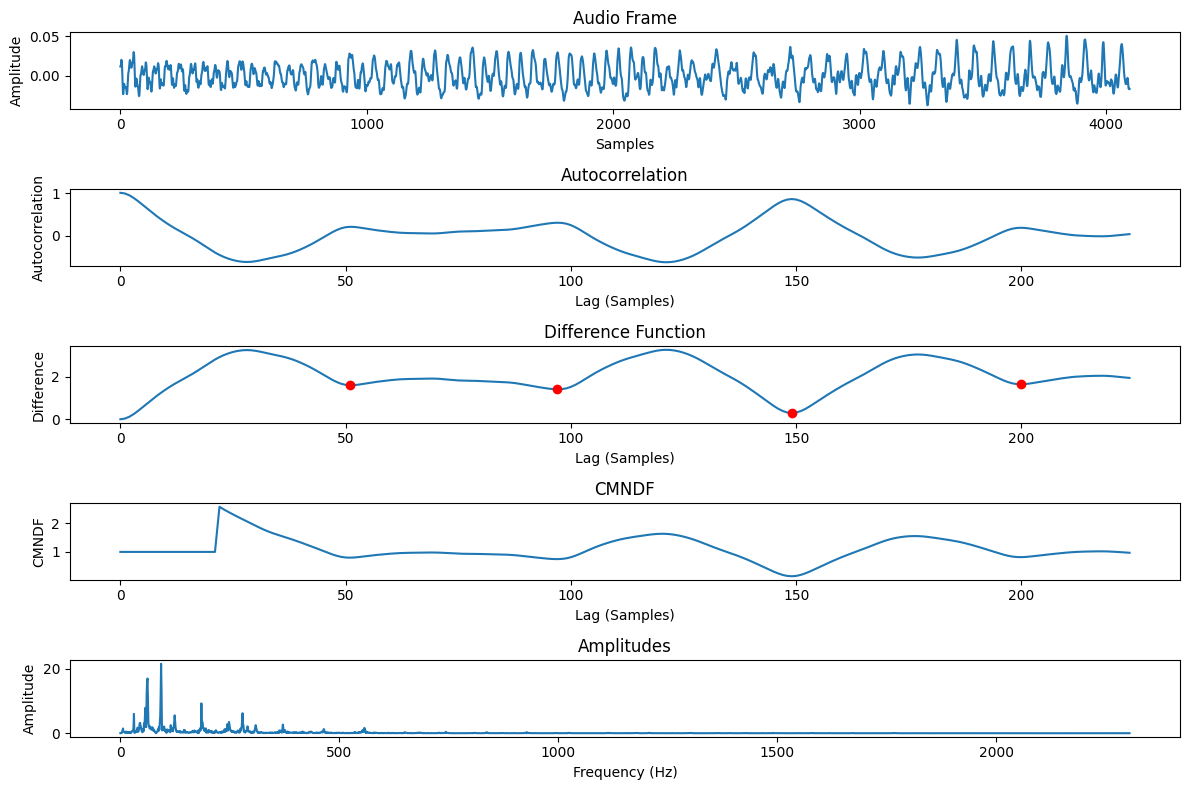

In [8]:
# params
MIN_VIOLIN_FREQ = 196.0
MAX_VIOLIN_FREQ = 2000
FRAME_SIZE = 2048*2

# get a frame from the filtered audio
start_time = 1.25
start_idx = int(start_time * SAMPLE_RATE)
end_idx = start_idx+FRAME_SIZE
audio_frame = iir_audio[start_idx:end_idx]
# audio_frame = iir_audio[FRAME_SIZE*20 : FRAME_SIZE*21] 

# ensure max lag is big enough to detect lowest f0 (largest period) of the violin
tau_max = int(SAMPLE_RATE/MIN_VIOLIN_FREQ)
tau_min = int(SAMPLE_RATE/MAX_VIOLIN_FREQ)
print(f"Computing pitches with tau_max = {tau_max}")

# call autocorrelation, diff_fct, cmndf on the audio
autocorr, _ = Yin.autocorrelation_fft(audio_frame, tau_max)
diff_frame, amplitudes = Yin.difference_function(audio_frame, tau_max)
cmndf_frame = Yin.cmndf(diff_frame, tau_max, tau_min)

# get the relative min
# diff_trough_indices = scipy.signal.argrelmin(diff_frame, order=1)[0]

prominence = int((np.max(diff_frame) - np.min(diff_frame))/2)
diff_trough_indices, _ = scipy.signal.find_peaks(-diff_frame, prominence=0.1, distance=5)

# ---
# Plot the results
fig, axs = plt.subplots(5, 1, figsize=(12, 8)) 

# original audio
axs[0].plot(audio_frame)
axs[0].set_title('Audio Frame')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

# autocorrelation result
axs[1].plot(autocorr)
axs[1].set_title('Autocorrelation')
axs[1].set_xlabel('Lag (Samples)')
axs[1].set_ylabel('Autocorrelation')

# difference function (no normalization)
axs[2].plot(diff_frame)
axs[2].set_title('Difference Function')
axs[2].set_xlabel('Lag (Samples)')
axs[2].set_ylabel('Difference')
axs[2].plot(diff_trough_indices, diff_frame[diff_trough_indices], 'ro')

# CMNDF (cumulative mean normalized diff fct)
axs[3].plot(cmndf_frame)
axs[3].set_title('CMNDF')
axs[3].set_xlabel('Lag (Samples)')
axs[3].set_ylabel('CMNDF')

# amplitudes for frequencies = abs(fft)
axs[4].plot(amplitudes)
axs[4].set_title('Amplitudes')
axs[4].set_xlabel('Frequency (Hz)')
axs[4].set_ylabel('Amplitude')

fig.tight_layout()
plt.show()

## Phase 2: Probabilistic thresholding

### 2.1: Modeling the threshold priors as beta distributions
YIN chooses a particular threshold and chooses the first trough in the CMNDF which is below that threshold, or the global minimum otherwise.

PYIN doesn't assume one threshold, and instead computes a weighted probability for all possible troughs after attempting all possible thresholds between $0-1$. Mauch-Dixon 2014 use a **beta distribution** with the following parameters:
1. Mean $=0.1$, $\alpha=1$, $\beta=18$
2. Mean $=0.15$, $\alpha=1$, $\beta=11 \frac{1}{3}$
3. Mean $=0.2$, $\alpha=1$, $\beta=8$

Though the paper says to use $\alpha=1$, when we plot them with `scipy.stats.beta.pdf` it seems that $\alpha=2$ produces the results that look the most like the plots from the paper, so we continue with $\alpha=2$ instead.

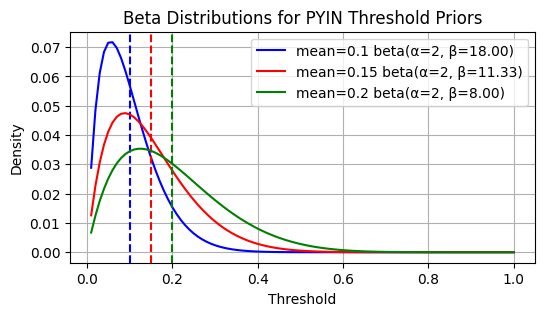

In [14]:
# Parameters for the beta distribution
# a, b, mean, color(for plotting)
beta_params = [
    (2, 18, .1, 'b'), # mean=0.1
    (2, 34/3, .15, 'r'), # mean=0.15
    (2, 8, .2, 'g') # mean=0.2
]

# all thresholds
N_THRESHOLDS = 100
x = np.linspace(0.01, 1, N_THRESHOLDS)

# plot
plt.figure(figsize=(6, 3))
for a, b, mean, col in beta_params:
    beta_pdf = beta.pdf(x, a, b) / N_THRESHOLDS  # compute the probability density function
    plt.plot(x, beta_pdf, label=f'mean={mean} beta(α={a}, β={b:.2f})', color=col)
    plt.axvline(mean, linestyle='--', color=col)

plt.title('Beta Distributions for PYIN Threshold Priors')
plt.xlabel('Threshold')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

### 2.2: Computing probability of a single pitch

We compute the probability that a given trough corresponds to the period for the fundamental frequency using the following formula given by the paper.

$$
P(\tau = \tau_0 | S, x_t) = \sum^N_{i=1}a(s_i, \tau) P(s_i) [Y(x_t, s_i)=\tau]
$$

#### Explanation
Basically, for a given trough in the CMNDF, we iterate through all possible thresholds $s_i \in S=[0.01, 1]$ and sum up the little probabilities given two possibilities:

Define a `total_pitch_prob` = 0.

Does YIN choose $\tau$ as the fundamental $\tau_0$ given the threshold $s_i$?

If yes:
1. If $d^\prime (\tau) <= s_i$, then `total_pitch_prob` += $P(s_i)$
2. Else if $d^\prime (\tau) > s_i$ then `total_pitch_prob` += $p_\alpha P(s_i)$

If no:
1. Do nothing

Where YES's case 2 corresponds to when the trough is one that would be chosen by YIN as a global minimum, BUT is not under the threshold. Then we call the pitch *unvoiced* at that $s_i$ and weight that particular probability less (multiply by $p_\alpha = 0.01$).

Freq estimates (Hz) from diff_fct: ['2641.17', '1257.20', '821.08', '624.12', '505.95', '419.15', '355.43', '312.22', '279.70', '251.46', '226.90', '208.21']
Midi number normalized: ['99.95', '87.10', '79.72', '74.97', '71.34', '68.08', '65.23', '62.98', '61.08', '59.24', '57.46', '55.97']


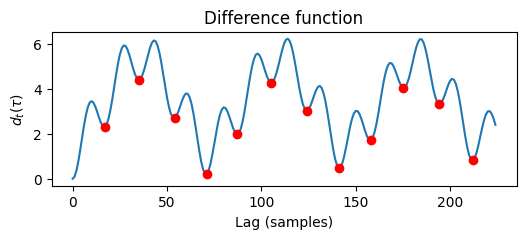

In [15]:
diff_trough_indices = scipy.signal.argrelmin(diff_frame, order=1)[0]

# parabolic interpolation for final candidates
tau_candidates = [Yin.parabolic_interpolation(diff_frame, t) for t in diff_trough_indices]

# print pitch estimates
freq_estimates = [SAMPLE_RATE/x for x in tau_candidates]
midi_estimates = [PitchConversion.freq_to_midi(f_0, tuning=442) for f_0 in freq_estimates]
print(f"Freq estimates (Hz) from diff_fct: {[f'{f_0:.2f}' for f_0 in freq_estimates]}")
print(f"Midi number normalized: {[f'{midi_num:.2f}' for midi_num in midi_estimates]}")

fig = plt.figure(figsize=(6,2))
axs = fig.add_subplot(1, 1, 1)

axs.plot(diff_frame)
axs.plot(diff_trough_indices, diff_frame[diff_trough_indices], 'ro')

axs.set_title("Difference function")
axs.set_xlabel("Lag (samples)")
axs.set_ylabel("$d_t(\\tau)$")

plt.show()

# the audio is consistent with the 501.14 Hz estimate! (B4)
ipd.Audio(audio_frame, rate=SAMPLE_RATE)

In [20]:
tau_probs = np.zeros_like(tau_candidates)

UNVOICED_PROBABILITY = 0.01
N_THRESHOLDS = 100
for s_i in range(1, N_THRESHOLDS):
	threshold = s_i / N_THRESHOLDS
	tau_0, tau_idx, is_voiced = Yin.absolute_threshold(cmndf_frame, diff_trough_indices, threshold=threshold)
	# tau_idx = np.where(diff_trough_indices == tau_0)[0]
	if is_voiced:
		tau_probs[tau_idx] += beta_pdf[s_i]
	else:
		tau_probs[tau_idx] += beta_pdf[s_i] * UNVOICED_PROBABILITY

unvoiced_prob = 1 - np.sum(tau_probs)

print(f"Freq estimates (Hz) from diff_fct: {[f'{f_0:.2f}' for f_0 in freq_estimates]}")
print(f"Probabilities: {[f'{prob:.2f}' for prob in tau_probs]}")
print(f"Unvoiced prob: {unvoiced_prob:.2f}")

Freq estimates (Hz) from diff_fct: ['592.06', '294.20']
Probabilities: ['0.00', '0.59']
Unvoiced prob: 0.41


In [5]:
# create pyin instance with tuning parameters
pyinner = PYin(sr=SAMPLE_RATE, f0_min=196, f0_max=2000, tuning=442)
pitches, most_likely_pitches, obs_mat = pyinner.pyin(iir_audio)

time 0.0: found 1 troughs?
time 0.0029024943310657597: found 1 troughs?
time 0.005804988662131519: found 1 troughs?
time 0.008707482993197279: found 1 troughs?
time 0.011609977324263039: found 1 troughs?
time 0.014512471655328799: found 1 troughs?
time 0.017414965986394557: found 1 troughs?
time 0.020317460317460317: found 1 troughs?
time 0.023219954648526078: found 1 troughs?
time 0.026122448979591838: found 1 troughs?
time 0.029024943310657598: found 1 troughs?
time 0.03192743764172336: found 1 troughs?
time 0.034829931972789115: found 1 troughs?
time 0.03773242630385488: found 1 troughs?
time 0.040634920634920635: found 1 troughs?
time 0.04353741496598639: found 1 troughs?
time 0.046439909297052155: found 1 troughs?
time 0.04934240362811791: found 1 troughs?
time 0.052244897959183675: found 1 troughs?
time 0.05514739229024943: found 1 troughs?
time 0.058049886621315196: found 1 troughs?
time 0.06095238095238095: found 1 troughs?
time 0.06385487528344672: found 1 troughs?
time 0.0667

In [11]:
pyinner.tau_min

22

In [7]:
# View the pitch estimates in the app
from app.ui.plots.PitchPlot import RunPitchPlot
from app.core.midi.MidiData import MidiData
from PyQt6.QtWidgets import QApplication
from PyQt6.QtCore import QCoreApplication


if __name__ == '__main__':
    if not QCoreApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QCoreApplication.instance()

    MIDI_FILEPATH = '../data/midi_files/fugue_midi.mid'
    midi_data = MidiData(MIDI_FILEPATH)

    # pitchplot = RunPitchPlot(
    #     app, midi_data=midi_data, pitches=most_likely_pitches, onsets=user_onset2_df.onset_df, align_df=align_df2
    # )
    pitchplot = RunPitchPlot(
        app, midi_data=midi_data, pitches=pitches
    )

Plotting pitches...
Done!


qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=615.213,405.804 gbl=615.213,405.804 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-615.213,-405.804 last=-615.213,-405.804 Δ 615.213,405.804) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=706.983,489.551 gbl=706.983,489.551 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-706.983,-489.551 last=-706.983,-489.551 Δ 706.983,489.551) : no target window


## Phase 3: HMM pitch tracking

Given a sequence of hidden states

## Phase 2: Probabilistic Thresholding
Based on modeling all possible thresholds for peak picking as a beta distribution centered around some mean (ex: 0.3)

Mean 0.3 has alpha: 6.0, beta: 14.0


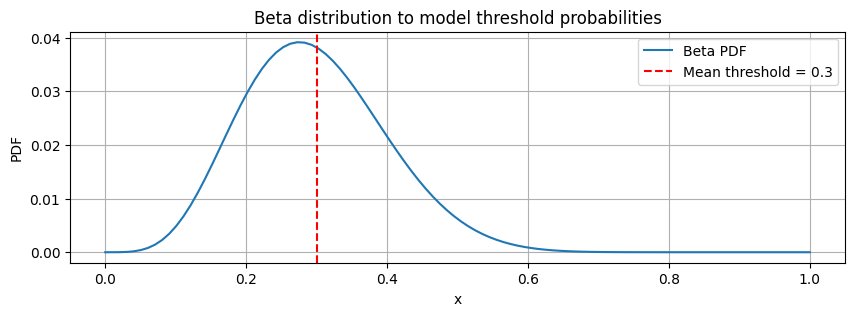

In [96]:
# Define the beta distribution with a total mass of 1
def calculate_alpha_beta(mean_threshold, total=20):
    """
    Calculate alpha and beta for a beta distribution given a desired mean and a total sum of alpha and beta.
    """
    alpha = mean_threshold * total
    beta = total - alpha
    return alpha, beta

N_THRESHOLDS = 100
thresholds = np.linspace(0, 1, N_THRESHOLDS) # add one because we create using np.diff of a cdf
cdf_thresholds = np.linspace(0, 1, N_THRESHOLDS + 1)

# Create beta distribution centered around the desired mean threshold
MEAN_THRESHOLD = 0.3
alpha, beta = PYin.calculate_alpha_beta(MEAN_THRESHOLD, total=20)
print(f"Mean {MEAN_THRESHOLD} has alpha: {alpha}, beta: {beta}")
beta_cdf = scipy.stats.beta.cdf(x=cdf_thresholds, a=alpha, b=beta) # How are alpha and beta calculated?
beta_pdf = np.diff(beta_cdf) # where we know the total mass = 1

# Plot the beta distribution and the mean threshold
plt.figure(figsize=(10, 3))
# plt.plot(beta_thresholds, beta_cdf, label=f'Beta CDF (mean={MEAN_THRESHOLD}, alpha={alpha:.2f}, beta={beta:.2f})')
plt.plot(thresholds, beta_pdf, label='Beta PDF')
plt.axvline(x=MEAN_THRESHOLD, color='red', linestyle='--', label=f'Mean threshold = {MEAN_THRESHOLD}')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Beta distribution to model threshold probabilities')
plt.legend()

plt.grid(True)
plt.show()

### Confused but can blackbox: Boltzmann distribution?
Still confused why a Boltzmann distribution is used in the computation of these probabilities. 

1. `trough_threshold_matrix` - We create a matrix of all troughs at all thresholds and whether they are below the threshold (True) or not (False).
2. `trough_ranks` - Count number of valid troughs for each threshold (add up all the Trues we've seen so far in each column)
3. `n_troughs` - The total count of valid troughs for each threshold (1D version of trough_ranks)

I am unsure how n_trouhgs and trough_ranks come together in the boltzmann.pmf function to create the trough prior probabilities.
But we then for each threshold, we multiply elementwise the prior prob + beta distribution for all troughs detected at that threshold.

### Confused and cannot blackbox: Voicing?
Also accounting for those troughs that are 'unvoiced' by finding the minimum probability trough after accounting for beta probabilities, ...?

Shape of the trough_threshold_matrix: (12, 99)


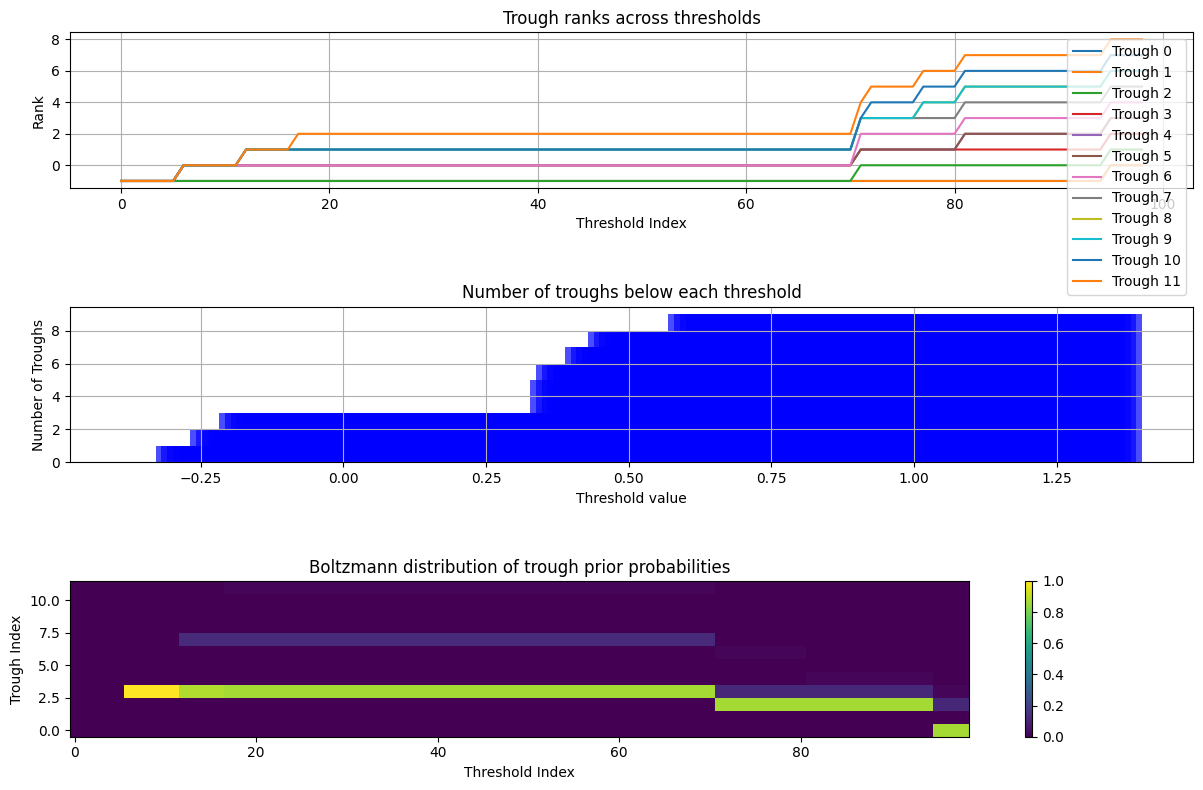

In [26]:
import matplotlib.pyplot as plt

trough_x_vals = np.array([trough[0] for trough in troughs])
trough_y_vals = np.array([trough[1] for trough in troughs])

N_THRESHOLDS = 100
thresholds = np.linspace(0, 1, N_THRESHOLDS)

# Boolean matrix indicating if the trough height is below the threshold
# for each pair-wise combination of trough y values and thresholds
#
# The shape of the resulting array is (n_troughs, n_thresholds), ex: (12, 100)
# rows = trough_heights, cols = threshold_vals
trough_threshold_matrix = np.less.outer(trough_y_vals, thresholds[1:])
print(f"Shape of the trough_threshold_matrix: {trough_threshold_matrix.shape}")

# Define prior over the troughs
# For each trough, replace the true/false with a count of how many true's it's seen so far
trough_ranks = np.cumsum(trough_threshold_matrix, axis=0)-1 # the index of the trough in the sorted list
n_troughs = np.count_nonzero(trough_threshold_matrix, axis=0)

# Define a Boltzmann distribution over the trough ranks
BOLTZMANN_PARAM = 2.0
trough_prior = scipy.stats.boltzmann.pmf(trough_ranks, BOLTZMANN_PARAM, n_troughs)
trough_prior[~trough_threshold_matrix] = 0

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# Plot the ranks of each trough across thresholds in the first subplot
for i in range(trough_ranks.shape[0]):
    axs[0].plot(trough_ranks[i], label=f'Trough {i}')

axs[0].set_xlabel('Threshold Index')
axs[0].set_ylabel('Rank')
axs[0].set_title('Trough ranks across thresholds')
axs[0].legend()
axs[0].grid(True)

# Plot the histogram of the number of troughs per threshold in the second subplot
axs[1].bar(thresholds[1:], n_troughs, color='b', alpha=0.7)
axs[1].set_xlabel('Threshold value')
axs[1].set_ylabel('Number of Troughs')
axs[1].set_title('Number of troughs below each threshold')
axs[1].grid(True)

# Plot the computed trough prior probabilities
# axs[2].plot(trough_prior)
# axs[2].set_title('Boltzmann distribution of trough prior probabilities')
# axs[2].set_xlabel('Trough Index')
# axs[2].set_ylabel('Prior Probability')
# axs[2].grid(True)

cax = axs[2].imshow(trough_prior, aspect='auto', origin='lower', cmap='viridis')
axs[2].set_title('Boltzmann distribution of trough prior probabilities')
axs[2].set_xlabel('Threshold Index')
axs[2].set_ylabel('Trough Index')
fig.colorbar(cax, ax=axs[2], orientation='vertical')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### View results: Probablistic thresholding

Seem to get good results aligned with what we expect!

In [14]:
import sys
sys.path.append('..')
from archive.PYin import PYin
from app.core.audio.AudioData import AudioData
import essentia.standard as es

AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0
SAMPLE_RATE = 44100

audio_data = AudioData()
audio_data.load_data(AUDIO_FILEPATH)

pitches, most_likely_pitches = PYin.pyin(audio_data)
# pitches, most_likely_pitches, voiced_probs, emission_matrix, transition_matrix = PYin.pyin(audio_data)

Starting pYIN algorithm...
Processing frame 4604/4604
Done!


## Phase 3: HMM-based pitch tracking
Using the viterbi algorithm to decode the hidden state (the true pitch sequence) for the audio.

### Emission matrix
Emission matrix stores the probabilities of going from a hidden state to every possible choice of observation.

In PYIN, we use the computed frame-wise set of pitches + probabilities to define the emission(observation) probabilities for the HMM. 

### Transition matrix
Transitions are defined as 

In [88]:
from app.algorithms.pitch.hmm.Viterbi import viterbi2
from app.algorithms.pitch.Pitch import Pitch, PitchConfig

# Run the Viterbi algorithm
state_sequence, max_prob = viterbi2(emission_matrix, transition_matrix)

# Recreate the pitch sequence from the state sequence
final_pitches = []
pitch_config = PitchConfig( # Defines resolution of pitch bins
    bins_per_semitone=10, tuning=440.0, fmin=196, fmax=3000
)
for i, state in enumerate(state_sequence):
    final_pitches.append(Pitch.bin_index_to_midi(state, pitch_config))


In [ ]:
for i, state in enumerate(state_sequence):
    print(f"Frame {i}: State {state}")

In [3]:
# Viterbi algorithm: Example viterbi_matrix, backpointer_matrix
import numpy as np
import sys
sys.path.append('..')
from app.algorithms.pitch.hmm.Viterbi import viterbi

# Test Case for Viterbi Algorithm

# Define the states
states = np.array([0, 1])  # Let's assume 0 = 'Healthy', 1 = 'Fever'

# Define the observations (observation sequence as indices)
observations = np.array([2, 1, 2, 0, 0])  # Let's assume 0 = 'normal', 1 = 'cold', 2 = 'dizzy'

# Define the initial state probabilities
initial_matrix = np.array([0.6, 0.4])  # P(Healthy) = 0.6, P(Fever) = 0.4

# Define the transition probabilities (from state i to state j)
transition_matrix = np.array([
    [0.7, 0.3],  # Healthy -> [Healthy, Fever]
    [0.4, 0.6]   # Fever -> [Healthy, Fever]
])

# Define the emission probabilities (state -> observation)
emission_matrix = np.array([
    [0.5, 0.4, 0.1],  # Healthy -> [normal, cold, dizzy]
    [0.1, 0.3, 0.6]   # Fever -> [normal, cold, dizzy]
])

# Run the Viterbi algorithm
state_sequence, max_probability, viterbi_matrix, backpointer_matrix = viterbi(
    observations, states, initial_matrix, transition_matrix, emission_matrix
)

# np.set_printoptions()
print(f"Most likely state sequence: {state_sequence}")
print(f"Max probability of the sequence: {max_probability}")
print(f"Viterbi matrix:\n{viterbi_matrix}")
print(f"Backpointer matrix:\n{backpointer_matrix}")

Most likely state sequence: [1 1 1 0 0]
Max probability of the sequence: 0.0010886399999999997
Viterbi matrix:
[[6.00000e-02 3.84000e-02 2.68800e-03 3.11040e-03 1.08864e-03]
 [2.40000e-01 4.32000e-02 1.55520e-02 9.33120e-04 9.33120e-05]]
Backpointer matrix:
[[0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0.]]


In [4]:
import numpy as np

# Simulated observation probabilities for 3 frames and 5 pitch bins
observation_probs = np.array([
    [0.2, 0.1, 0.05],  # Frame 1 probabilities for 5 pitch bins
    [0.3, 0.2, 0.15],
    [0.1, 0.05, 0.1],
    [0.25, 0.15, 0.2],
    [0.15, 0.5, 0.25]
])

print("Observation probabilities:\n", observation_probs)

# Summing probabilities across pitch bins (columns)
voiced_prob = np.sum(observation_probs, axis=0)
print("\nSummed voiced probabilities (before clipping):\n", voiced_prob)

# Ensure the voiced probability is between 0 and 1
voiced_prob_clipped = np.clip(voiced_prob, 0, 1)
print("\nVoiced probabilities (after clipping):\n", voiced_prob_clipped)

Observation probabilities:
 [[0.2  0.1  0.05]
 [0.3  0.2  0.15]
 [0.1  0.05 0.1 ]
 [0.25 0.15 0.2 ]
 [0.15 0.5  0.25]]

Summed voiced probabilities (before clipping):
 [1.   1.   0.75]

Voiced probabilities (after clipping):
 [1.   1.   0.75]
